In [6]:
import sys

import matplotlib.pyplot as plt

%matplotlib notebook
%matplotlib notebook
## save variables
import pickle
## folder names
from glob import glob
## standard libraries
import numpy as np

##
#from sklearn.decomposition import PCA
#from sklearn.preprocessing import normalize


#!{sys.executable} -m pip install tensorflow-gpu --user
#!{sys.executable} -m pip install keras --user
import tensorflow as tf
from keras import backend as k

import keras
from keras.optimizers import SGD, Adam
#!{sys.executable} -m pip install hyperas --user
#!{sys.executable} -m pip install networkx==1.11 --user

from hyperas import optim
from hyperas.distributions import choice, uniform, conditional
from hyperopt import Trials, STATUS_OK, tpe

import os.path
import datetime

from dependencies import models
from dependencies import functions

from dependencies.convnet_drawer.convnet_drawer import Model
from dependencies.convnet_drawer.convnet_drawer import Conv2D
from dependencies.convnet_drawer.convnet_drawer import MaxPooling2D as MaxPooling2D_drawer
from dependencies.convnet_drawer.convnet_drawer import Flatten as Flatten_drawer
from dependencies.convnet_drawer.convnet_drawer import Dense as Dense_drawer
from dependencies.convnet_drawer.matplotlib_util import save_model_to_file
from dependencies.convnet_drawer.keras_util import convert_drawer_model

# Import data

In [2]:
#choose which dictionary to use
choice =     'logfilter' # 'mfcc'#
useDelta =  True
#retrieving of used values for the computation of mfcc
with open('variables/mfccValues.pkl', 'rb') as f:  
    values = pickle.load(f)
selected = 0
if choice == 'mfcc':     
    #name format of the selected data
    if useDelta:
        name = 'variables/mfccDict_DD[nC='+str(values[selected][0])+' wL='+str(values[selected][2])+' wS='+str(values[selected][3])+'].pkl'
    else:
        name = 'variables/mfccDict[nC='+str(values[selected][0])+' wL='+str(values[selected][2])+' wS='+str(values[selected][3])+'].pkl'
    #loading in usedDict of the mfcc dict
    with open(name, 'rb') as f: 
        usedDict = pickle.load(f)
    print('Loaded '+name)

elif choice == 'logfilter':
    #name format of the selected data
    if useDelta:
        name = 'variables/logfiltDict_DD[nF='+str(values[selected][1])+' wL='+str(values[selected][2])+' wS='+str(values[selected][3])+'].pkl'
    else:
        name = 'variables/logfiltDict[nF='+str(values[selected][1])+' wL='+str(values[selected][2])+' wS='+str(values[selected][3])+'].pkl'
    #saving in usedDict of the logfilter dict
    with open(name, 'rb') as f:  
        usedDict = pickle.load(f)
    print('Loaded '+name)

Loaded variables/logfiltDict_DD[nF=26 wL=0.025 wS=0.01].pkl


# Acquiring and scaling data

In [3]:
#core words of the dataset
coreKey = ["yes", "no", "up", "down", "left", "right", "on", "off", "stop", "go", "zero",
           "one", "two", "three", "four", "five", "six", "seven", "eight", "nine"]

#split of the core set
numbers = ['one', 'two', 'three','four','five','six','seven','eight','nine', "zero"]

words = ["yes", "no", "up", "down", "left", "right", "on", "off", "stop", "go"]

#selecting the subset of words to predict
used = words

used.append('silence')

unknown = list(usedDict.keys())
for key in used:
    try:
        unknown.remove(key)
    except:
        print(key, ' not in used')

In [4]:
%%time
#divding between train and test with also scaling data
functions.train_test_creator(
    {k: usedDict[k] for k in usedDict.keys() & used },
    {k: usedDict[k] for k in usedDict.keys() & unknown },
    with_unknown = False,
    scalerType = 'robust',
    depth = (len(usedDict[words[0]].shape)-3)*2 + 1 )
print()


Wall time: 1min 39s


## Reset variables to free RAM

In [5]:
%reset -f
from IPython.display import Javascript
Javascript("Jupyter.notebook.execute_cells([0])")

<IPython.core.display.Javascript object>

In [7]:
x_train, y_train, x_test, y_test = functions.data()
with open('variables/labelList.pkl', 'rb') as f: 
        labelList = pickle.load(f)

# Fitting

## Fitting variables

In [8]:
from functools import partial

# TensorFlow wizardry
config = tf.ConfigProto()
 
# Don't pre-allocate memory; allocate as-needed
config.gpu_options.allow_growth = True
 
# Only allow a total 0.9 of the GPU memory to be allocated
config.gpu_options.per_process_gpu_memory_fraction = 0.8
 
# Create a session with the above options specified.
k.tensorflow_backend.set_session(tf.Session(config=config))

epoch = 15
epochSGD = 15

adam = Adam(lr=0.001, beta_1=0.9, beta_2=0.999, epsilon=None, decay=0.001/epoch, amsgrad=True)
sgd = SGD(lr=0.001, decay=0.001/epochSGD, momentum=0.9, nesterov=True)

top3_acc = partial(keras.metrics.top_k_categorical_accuracy, k=3)
top3_acc.name = 'top3_acc'

dest_directory = 'model_backup/'
if not os.path.exists(dest_directory):
      os.makedirs(dest_directory)

tbCallBack = keras.callbacks.TensorBoard(log_dir='./Graph', histogram_freq=0, write_graph=True, write_images=True)

In [ ]:
def w_categorical_crossentropy(y_true, y_pred, weights):
    nb_cl = len(weights)
    final_mask = K.zeros_like(y_pred[:, 0])
    y_pred_max = K.max(y_pred, axis=1)
    y_pred_max = K.reshape(y_pred_max, (K.shape(y_pred)[0], 1))
    y_pred_max_mat = K.cast(K.equal(y_pred, y_pred_max), K.floatx())
    for c_p, c_t in product(range(nb_cl), range(nb_cl)):
        final_mask += (weights[c_t, c_p] * y_pred_max_mat[:, c_p] * y_true[:, c_t])
    return K.categorical_crossentropy(y_pred, y_true) * final_mask

## Sequential Models

MODEL1
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_422 (Conv2D)          (None, 93, 23, 64)        5376      
_________________________________________________________________
batch_normalization_170 (Bat (None, 93, 23, 64)        256       
_________________________________________________________________
max_pooling2d_110 (MaxPoolin (None, 31, 11, 64)        0         
_________________________________________________________________
dropout_101 (Dropout)        (None, 31, 11, 64)        0         
_________________________________________________________________
conv2d_423 (Conv2D)          (None, 28, 10, 128)       65536     
_________________________________________________________________
batch_normalization_171 (Bat (None, 28, 10, 128)       512       
_________________________________________________________________
conv2d_424 (Conv2D)          (None, 25, 8, 256)        393216    
___

<IPython.core.display.Javascript object>


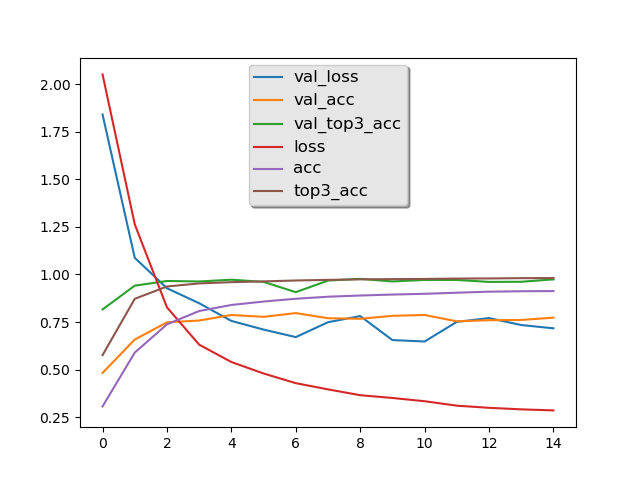

<IPython.core.display.Javascript object>


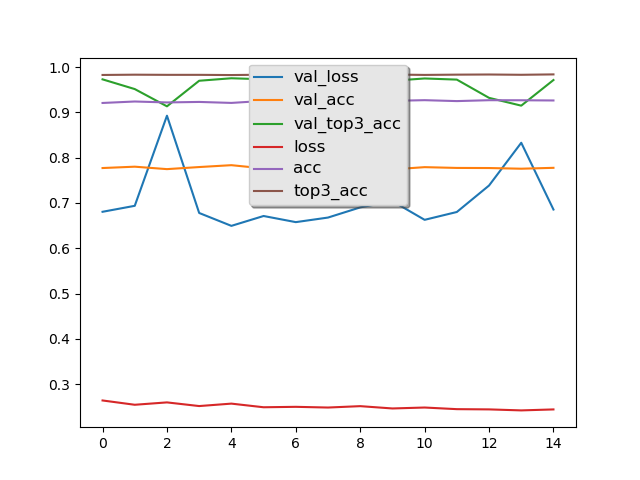

Wall time: 8min


In [129]:
%%time

print("MODEL1")
cnn = models.model1(x_train,y_train, depth = x_train.shape[3])

cnn.summary()


compiledAdam = cnn.compile(loss="categorical_crossentropy", optimizer=adam, metrics=['accuracy', top3_acc])
fittedAdam = cnn.fit(x_train, y_train,
                     epochs=epoch,
                     validation_data=(x_test, y_test),
                     batch_size=round(x_train.shape[0]/300),
                     shuffle=True,
                     callbacks = [tbCallBack])

compiledSGD = cnn.compile(loss="categorical_crossentropy", optimizer=sgd, metrics=['accuracy', top3_acc])

fittedSGD = cnn.fit(x_train, y_train, 
                epochs=epochSGD, 
                validation_data=(x_test, y_test), 
                batch_size=round(x_train.shape[0]/300), 
                shuffle=True,
                callbacks = [tbCallBack])

fig, ax = plt.subplots()
x = range(epoch)
for key in fittedAdam.history:
    ax.plot(x,fittedAdam.history[key],label=key)
legend = ax.legend(loc='upper center', shadow=True)
frame = legend.get_frame()
frame.set_facecolor('0.90')
for label in legend.get_texts():
    label.set_fontsize('large')

for label in legend.get_lines():
    label.set_linewidth(1.5)  # the legend line width

fig, ax = plt.subplots()
x = range(epochSGD)
for key in fittedSGD.history:
    ax.plot(x,fittedSGD.history[key],label=key)
legend = ax.legend(loc='upper center', shadow=True)
frame = legend.get_frame()
frame.set_facecolor('0.90')
for label in legend.get_texts():
    label.set_fontsize('large')

for label in legend.get_lines():
    label.set_linewidth(1.5)  # the legend line width


plt.show()

name = 'cnn1.bak'
#cnn.save(dest_directory + name)


MODEL3
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_425 (Conv2D)          (None, 96, 25, 32)        800       
_________________________________________________________________
activation_303 (Activation)  (None, 96, 25, 32)        0         
_________________________________________________________________
conv2d_426 (Conv2D)          (None, 96, 25, 64)        8256      
_________________________________________________________________
activation_304 (Activation)  (None, 96, 25, 64)        0         
_________________________________________________________________
conv2d_427 (Conv2D)          (None, 96, 25, 128)       32768     
_________________________________________________________________
batch_normalization_174 (Bat (None, 96, 25, 128)       512       
_________________________________________________________________
activation_305 (Activation)  (None, 96, 25, 128)       0         
__

<IPython.core.display.Javascript object>


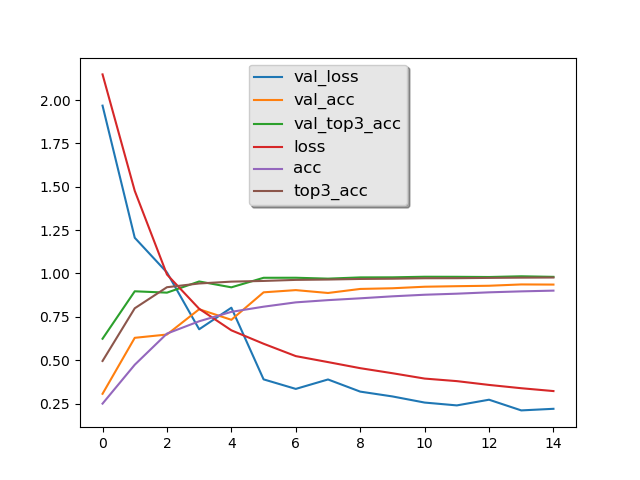

<IPython.core.display.Javascript object>


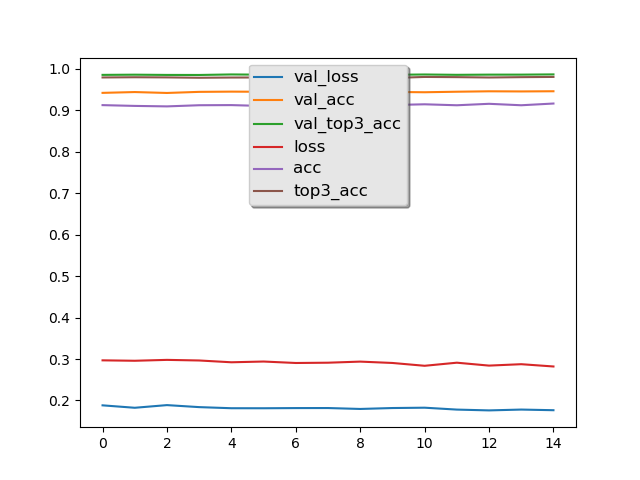

Wall time: 11min 6s


In [130]:
%%time
print("\nMODEL3")
cnn = models.model3(x_train,y_train, depth = x_train.shape[3], baseDim = 32)

cnn.summary()


compiledAdam = cnn.compile(loss="categorical_crossentropy", optimizer=adam, metrics=['accuracy', top3_acc])
fittedAdam = cnn.fit(x_train, y_train,
                     epochs=epoch,
                     validation_data=(x_test, y_test),
                     batch_size=round(x_train.shape[0]/200),
                     shuffle=True,
                     callbacks = [tbCallBack])

compiledSGD = cnn.compile(loss="categorical_crossentropy", optimizer=sgd, metrics=['accuracy', top3_acc])

fittedSGD = cnn.fit(x_train, y_train, 
                epochs=epochSGD, 
                validation_data=(x_test, y_test), 
                batch_size=round(x_train.shape[0]/200), 
                shuffle=True,
                callbacks = [tbCallBack])

fig, ax = plt.subplots()
x = range(epoch)
for key in fittedAdam.history:
    ax.plot(x,fittedAdam.history[key],label=key)
legend = ax.legend(loc='upper center', shadow=True)
frame = legend.get_frame()
frame.set_facecolor('0.90')
for label in legend.get_texts():
    label.set_fontsize('large')

for label in legend.get_lines():
    label.set_linewidth(1.5)  # the legend line width

fig, ax = plt.subplots()
x = range(epochSGD)
for key in fittedSGD.history:
    ax.plot(x,fittedSGD.history[key],label=key)
legend = ax.legend(loc='upper center', shadow=True)
frame = legend.get_frame()
frame.set_facecolor('0.90')
for label in legend.get_texts():
    label.set_fontsize('large')

for label in legend.get_lines():
    label.set_linewidth(1.5)  # the legend line width
    
plt.show()

name = 'cnn3.bak'
#cnn.save(dest_directory + name)


TINYDARKNET
Train on 34836 samples, validate on 8710 samples
Epoch 1/15
34836/34836 [==============================] - 30s 867us/step - loss: 1.7121 - acc: 0.6083 - top3_acc: 0.8237 - val_loss: 0.6388 - val_acc: 0.8261 - val_top3_acc: 0.9462
Epoch 2/15
34836/34836 [==============================] - 24s 697us/step - loss: 0.3981 - acc: 0.8886 - top3_acc: 0.9745 - val_loss: 0.3874 - val_acc: 0.8978 - val_top3_acc: 0.9741
Epoch 3/15
34836/34836 [==============================] - 25s 709us/step - loss: 0.2908 - acc: 0.9205 - top3_acc: 0.9809 - val_loss: 0.2862 - val_acc: 0.9209 - val_top3_acc: 0.9793
Epoch 4/15
34836/34836 [==============================] - 25s 707us/step - loss: 0.2434 - acc: 0.9332 - top3_acc: 0.9844 - val_loss: 0.2539 - val_acc: 0.9301 - val_top3_acc: 0.9837
Epoch 5/15
34836/34836 [==============================] - 24s 699us/step - loss: 0.2150 - acc: 0.9408 - top3_acc: 0.9860 - val_loss: 0.2446 - val_acc: 0.9334 - val_top3_acc: 0.9805
Epoch 6/15
34836/34836 [=========

<IPython.core.display.Javascript object>


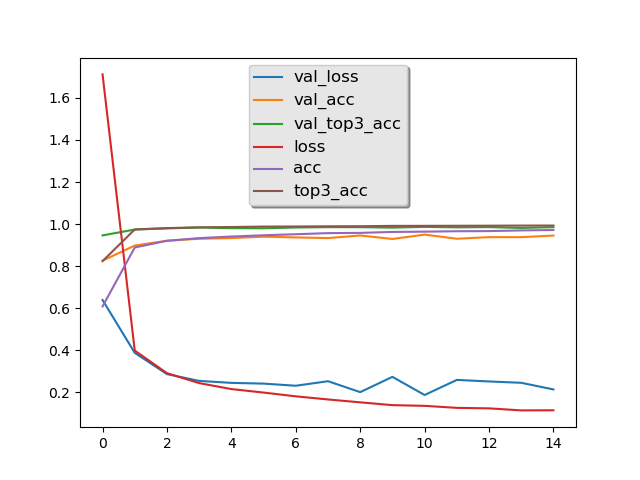

<IPython.core.display.Javascript object>


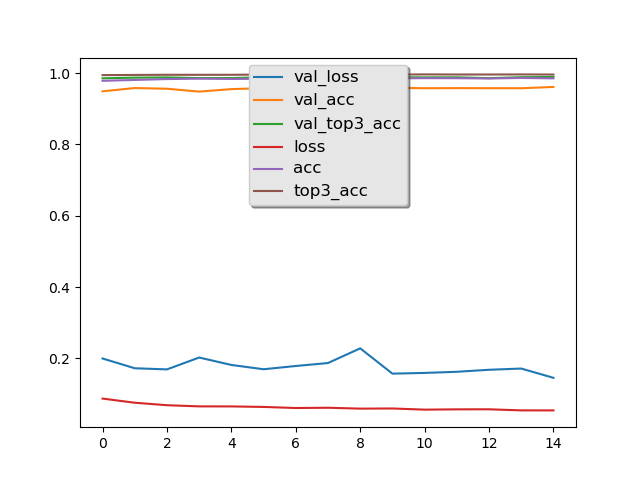

Wall time: 13min 18s


In [131]:
%%time
print("\nTINYDARKNET")
cnn = models.tinyDarknet(x_train,y_train, depth = x_train.shape[3], dropout = 0.05)



compiledAdam = cnn.compile(loss="categorical_crossentropy", optimizer=adam, metrics=['accuracy', top3_acc])
fittedAdam = cnn.fit(x_train, y_train,
                     epochs=epoch,
                     validation_data=(x_test, y_test),
                     batch_size=round(x_train.shape[0]/200),
                     shuffle=True,
                     callbacks = [tbCallBack])


compiledSGD = cnn.compile(loss="categorical_crossentropy", optimizer=sgd, metrics=['accuracy', top3_acc])

fittedSGD = cnn.fit(x_train, y_train, 
                epochs=epochSGD, 
                validation_data=(x_test, y_test), 
                batch_size=round(x_train.shape[0]/200), 
                shuffle=True,
                callbacks = [tbCallBack])

fig, ax = plt.subplots()
x = range(epoch)
for key in fittedAdam.history:
    ax.plot(x,fittedAdam.history[key],label=key)
legend = ax.legend(loc='upper center', shadow=True)
frame = legend.get_frame()
frame.set_facecolor('0.90')
for label in legend.get_texts():
    label.set_fontsize('large')

for label in legend.get_lines():
    label.set_linewidth(1.5)  # the legend line width

fig, ax = plt.subplots()
x = range(epochSGD)
for key in fittedSGD.history:
    ax.plot(x,fittedSGD.history[key],label=key)
legend = ax.legend(loc='upper center', shadow=True)
frame = legend.get_frame()
frame.set_facecolor('0.90')
for label in legend.get_texts():
    label.set_fontsize('large')

for label in legend.get_lines():
    label.set_linewidth(1.5)  # the legend line width
    
plt.show()

name = 'cnn4.bak'
#cnn.save(dest_directory + name)

In [132]:
cnn.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dropout_108 (Dropout)        (None, 99, 26, 3)         0         
_________________________________________________________________
conv2d_431 (Conv2D)          (None, 99, 26, 32)        864       
_________________________________________________________________
batch_normalization_179 (Bat (None, 99, 26, 32)        128       
_________________________________________________________________
leaky_re_lu_106 (LeakyReLU)  (None, 99, 26, 32)        0         
_________________________________________________________________
dropout_109 (Dropout)        (None, 99, 26, 32)        0         
_________________________________________________________________
conv2d_432 (Conv2D)          (None, 99, 26, 16)        4608      
_________________________________________________________________
batch_normalization_180 (Bat (None, 99, 26, 16)        64        
__________

In [ ]:
#!tensorboard --logdir Graph/

# Inception

In [9]:
from keras.layers import Input
from keras.layers import Flatten, Dense, Activation, BatchNormalization, Dropout, SpatialDropout2D
from keras.layers import Conv2D, MaxPooling2D, AveragePooling2D, GlobalAveragePooling2D
from keras import regularizers
from keras.models import Model


def cBN(inputLayer, filt = 64, size = (1,1), padding = 'same', activation = 'relu', regu = 0.0, dropout = 0.05, strides = (1,1)):
    cbn = Conv2D(filt, size, padding=padding, use_bias=False, kernel_regularizer=regularizers.l2(regu), strides = (1,1))(inputLayer)
    cbn = Activation(activation)(cbn)
    #cbn = BatchNormalization(epsilon=1e-05, momentum=0.1, axis=-1)(cbn)
    return cbn

def inception(inputLayer, filt = 64):
    tower_1 = cBN(inputLayer, filt = filt)   
    tower_1 = cBN(tower_1, size = (3,3), filt = filt)

    tower_2 = cBN(inputLayer, filt = filt)
    tower_2 = cBN(tower_2, size = (5,5), filt = filt)

    tower_3 = MaxPooling2D((3,2), strides=(1,1), padding='same')(inputLayer)
    tower_3 = cBN(tower_3, filt = filt)
    
    #tower_4 = cBN(inputLayer)

    output = keras.layers.concatenate([tower_1, tower_2, tower_3], axis = 3)
    return output

## Single output

In [11]:
input_img = Input(name = 'input', shape = (x_train.shape[1], x_train.shape[2], x_train.shape[3]))

#output = inception(input_img, filt = 20)
output = inception(input_img, filt = 30)

output = MaxPooling2D(pool_size=(3,2), padding='same')(output)
output = SpatialDropout2D(0.15)(output)

#output = inception(output,filt = 30)
output = inception(output, filt = 40)

output = MaxPooling2D(pool_size=(3,2), padding='same')(output)
output = SpatialDropout2D(0.15)(output)

#output = inception(output, filt = 40)
output = inception(output, filt = 60)

output = MaxPooling2D(pool_size=(3,2), padding='same')(output)
output = SpatialDropout2D(0.15)(output)

#output = inception(output, filt = 60)
output = inception(output, filt = 100)

output = GlobalAveragePooling2D()(output)
#output = Dropout(0.2)(output)

output = Dense(100)(output)
#output = BatchNormalization(epsilon=1e-05, momentum=0.1)(output)
output = Activation('relu')(output)
output = Dropout(0.4)(output)
output = Dense(y_train.shape[1], name = 'output2', activation='softmax')(output)

In [135]:
cnn = Model(inputs = input_img, outputs = output)
validation_data=({'input': x_test}, {'output2': y_test})
cnn.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input (InputLayer)              (None, 99, 26, 3)    0                                            
__________________________________________________________________________________________________
conv2d_447 (Conv2D)             (None, 99, 26, 30)   90          input[0][0]                      
__________________________________________________________________________________________________
conv2d_449 (Conv2D)             (None, 99, 26, 30)   90          input[0][0]                      
__________________________________________________________________________________________________
activation_310 (Activation)     (None, 99, 26, 30)   0           conv2d_447[0][0]                 
__________________________________________________________________________________________________
activation

In [136]:
compiledAdam = cnn.compile(loss="categorical_crossentropy", optimizer=adam, metrics=['categorical_accuracy', top3_acc], loss_weights={'output2' : 1.})
fittedAdam = cnn.fit(x_train,  y_train,
                     epochs=epoch,
                     batch_size=round(x_train.shape[0]/400),
                     shuffle=True,
                     validation_data=validation_data, 
                     callbacks = [tbCallBack])
compiledSGD = cnn.compile(loss="categorical_crossentropy", optimizer=sgd, metrics=['accuracy', top3_acc], loss_weights={'output2' : 1.})
fittedSGD = cnn.fit(x_train, y_train,
                     epochs=epochSGD,
                     batch_size=round(x_train.shape[0]/400),
                     validation_data=validation_data,
                     shuffle=True,
                     callbacks = [tbCallBack])

Train on 34836 samples, validate on 8710 samples
Epoch 1/15
34836/34836 [==============================] - 23s 674us/step - loss: 2.1134 - categorical_accuracy: 0.2316 - top3_acc: 0.4682 - val_loss: 1.7723 - val_categorical_accuracy: 0.3387 - val_top3_acc: 0.6559
Epoch 2/15
34836/34836 [==============================] - 18s 531us/step - loss: 1.5160 - categorical_accuracy: 0.4418 - top3_acc: 0.7551 - val_loss: 0.8514 - val_categorical_accuracy: 0.7070 - val_top3_acc: 0.9315
Epoch 3/15
34836/34836 [==============================] - 18s 530us/step - loss: 0.8835 - categorical_accuracy: 0.6894 - top3_acc: 0.9216 - val_loss: 0.5477 - val_categorical_accuracy: 0.8191 - val_top3_acc: 0.9649
Epoch 4/15
34836/34836 [==============================] - 19s 533us/step - loss: 0.6491 - categorical_accuracy: 0.7783 - top3_acc: 0.9511 - val_loss: 0.4017 - val_categorical_accuracy: 0.8724 - val_top3_acc: 0.9683
Epoch 5/15
34836/34836 [==============================] - 18s 531us/step - loss: 0.5072 - c

## Multiple input

In [17]:
mfcc = False
from keras.layers.advanced_activations import LeakyReLU
def lin_inception(inputLayer, filt = 64, base = 3):
    tower_1 = cBN(inputLayer, filt = filt)   
    tower_1 = cBN(tower_1, size = (base,1), filt = filt)

    tower_2 = cBN(inputLayer, filt = filt)
    tower_2 = cBN(tower_2, size = (base+1,1), filt = filt)

    tower_3 = cBN(inputLayer, filt = filt)
    tower_3 = cBN(tower_3, filt = filt, size = (base+2,1))
    
    output = keras.layers.concatenate([tower_1, tower_2, tower_3], axis = 3)
    return output

def inception(inputLayer, filt = 64, base = 3):
    tower_1 = cBN(inputLayer, filt = filt)   
    tower_1 = cBN(tower_1, size = (base,base), filt = filt)

    tower_2 = cBN(inputLayer, filt = filt)
    tower_2 = cBN(tower_2, size = (base+2,base+2), filt = filt)
    
    tower_3 = MaxPooling2D((3,3), strides=(1,1), padding='same')(inputLayer)
    tower_3 = cBN(tower_3, filt = filt)
    output = keras.layers.concatenate([tower_1, tower_2, tower_3], axis = 3)
    return output

def singleInputMFCC(x_train, name, mfcc = True):
    single_input = Input(name = name, shape = (x_train.shape[1], x_train.shape[2], 1))
    if mfcc:
        output = Conv2D(120, (3,round(x_train.shape[2])))(single_input)
        output = lin_inception(output, filt = 80, base = 3)
        '''
    else:
        output = Conv2D(120, (6,6))(single_input)
        output = inception(output, filt = 80, base = 3)
    '''
    else:
        output = Conv2D(32, (3,3), padding = "same")(single_input)
        output = LeakyReLU(alpha=.1)(output)
        output = Conv2D(16, (3,3), padding = "same")(output)
        output = LeakyReLU(alpha=.1)(output)
        output = MaxPooling2D(pool_size=(2,2))(output)
        output = Conv2D(16, (1,1), padding = "same")(output)
        output = LeakyReLU(alpha=.1)(output)
        output = Conv2D(64, (3,3), padding = "same")(output)
        output = LeakyReLU(alpha=.1)(output)
        output = Conv2D(16, (1,1), padding = "same")(output)
        output = LeakyReLU(alpha=.1)(output)
        output = Conv2D(64, (3,3), padding = "same")(output)
        output = LeakyReLU(alpha=.1)(output)
        output = MaxPooling2D(pool_size=(2,2))(output)
        output = Conv2D(16, (1,1), padding = "same")(output)
        output = LeakyReLU(alpha=.1)(output)
        output = Conv2D(64, (3,3), padding = "same")(output)
        output = LeakyReLU(alpha=.1)(output)
        output = Conv2D(16, (1,1), padding = "same")(output)
        output = LeakyReLU(alpha=.1)(output)
        output = Conv2D(64, (3,3), padding = "same")(output)
        output = LeakyReLU(alpha=.1)(output)
        #output = MaxPooling2D(pool_size=(5,3))(output)
        #output = inception(output, filt = 40, base = 3)       
    
    return single_input, output
def firstConcat(x_train, mfcc = True):
    first, first_output = singleInputMFCC(x_train,'first', mfcc = mfcc)
    second, second_output = singleInputMFCC(x_train,'second', mfcc = mfcc)
    third, third_output = singleInputMFCC(x_train,'third', mfcc = mfcc)
    concat = keras.layers.concatenate([first_output, second_output, third_output], axis = 3)
    return first, second, third, concat

first_input, second_input, third_input, concat = firstConcat(x_train, mfcc = mfcc)

if mfcc:
    output = MaxPooling2D(pool_size=(3,1), padding='same')(concat)
    output = Dropout(0.05)(output)
    output = lin_inception(output, filt = 80, base = 3)
else:
    output = MaxPooling2D(pool_size=(5,3), padding='same')(concat)
    #output = Dropout(0.15)(output)
    output = inception(output, filt = 60, base = 2)
    #output = MaxPooling2D(pool_size=(3,3), padding='same')(output)
#output = lin_inception(output, filt = 80, base = 3)
if mfcc:
    output = AveragePooling2D((11,1))(output)
else:
    output = GlobalAveragePooling2D()(output)
#output = cBN(output, filt = 64)
#output = Flatten()(output)
output = Dense(70)(output)
output = Activation('relu')(output)
output = Dropout(0.4)(output)

output = Dense(y_train.shape[1], name = 'output', activation='softmax')(output)



In [18]:
cnn = Model(inputs = [first_input, second_input, third_input], outputs = output)
validation_data=({'first': x_test[:,:,:,0, np.newaxis], 'second': x_test[:,:,:,1, np.newaxis], 'third': x_test[:,:,:,2, np.newaxis]}, {'output': y_test})

cnn.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
first (InputLayer)              (None, 99, 26, 1)    0                                            
__________________________________________________________________________________________________
second (InputLayer)             (None, 99, 26, 1)    0                                            
__________________________________________________________________________________________________
third (InputLayer)              (None, 99, 26, 1)    0                                            
__________________________________________________________________________________________________
conv2d_71 (Conv2D)              (None, 99, 26, 32)   320         first[0][0]                      
__________________________________________________________________________________________________
conv2d_81 

In [19]:
compiledAdam = cnn.compile(loss="categorical_crossentropy", optimizer=adam, metrics=['accuracy', top3_acc], loss_weights={'output' : 1.})
fittedAdam = cnn.fit([x_train[:,:,:,0, np.newaxis], x_train[:,:,:,1, np.newaxis], x_train[:,:,:,2, np.newaxis]],  y_train,
                     epochs=epoch,
                     batch_size=round(x_train.shape[0]/400),
                     shuffle=True,
                     validation_data=validation_data, 
                     callbacks = [tbCallBack])

compiledSGD = cnn.compile(loss="categorical_crossentropy", optimizer=sgd, metrics=['accuracy', top3_acc], loss_weights={'output' : 1.})
fittedSGD = cnn.fit([x_train[:,:,:,0, np.newaxis], x_train[:,:,:,1, np.newaxis], x_train[:,:,:,2, np.newaxis]],  y_train,
                     epochs=epochSGD,
                     batch_size=round(x_train.shape[0]/400),
                     shuffle=True,
                     validation_data=validation_data, 
                     callbacks = [tbCallBack])

Train on 44088 samples, validate on 11022 samples
Epoch 1/15
44088/44088 [==============================] - 37s 842us/step - loss: 1.4328 - acc: 0.4813 - top3_acc: 0.7497 - val_loss: 0.7056 - val_acc: 0.7611 - val_top3_acc: 0.9430
Epoch 2/15
44088/44088 [==============================] - 35s 792us/step - loss: 0.6024 - acc: 0.8019 - top3_acc: 0.9533 - val_loss: 0.4189 - val_acc: 0.8606 - val_top3_acc: 0.9675
Epoch 3/15
44088/44088 [==============================] - 35s 792us/step - loss: 0.4423 - acc: 0.8602 - top3_acc: 0.9657 - val_loss: 0.3452 - val_acc: 0.8887 - val_top3_acc: 0.9741
Epoch 4/15
44088/44088 [==============================] - 35s 783us/step - loss: 0.3632 - acc: 0.8881 - top3_acc: 0.9730 - val_loss: 0.3295 - val_acc: 0.8972 - val_top3_acc: 0.9747
Epoch 5/15
44088/44088 [==============================] - 35s 784us/step - loss: 0.3156 - acc: 0.9032 - top3_acc: 0.9756 - val_loss: 0.2787 - val_acc: 0.9102 - val_top3_acc: 0.9778
Epoch 6/15
44088/44088 [=====================

KeyboardInterrupt: 

## Multiple output

In [10]:
def extraClassifier(name, inputLayer, outputShape):
    output0 = GlobalAveragePooling2D()(inputLayer)
    output0 = Dense(100, activation = 'relu')(output0)
    output0 = Dropout(0.7)(output0)
    output0 = Dense( outputShape, name = name, activation='softmax')(output0)
    return output0

In [14]:
input_img = Input(name = 'input', shape = (x_train.shape[1], x_train.shape[2], x_train.shape[3]))

output = cBN(input_img)
output = cBN(output, size = (3,3))
output = cBN(output)
output = cBN(output, size = (3,3))

output = MaxPooling2D(pool_size=(3,2), padding='same')(output)

output = inception(output)
output0 = extraClassifier('output0', output, y_train.shape[1])
#output = inception(output)

output = MaxPooling2D(pool_size=(3,2), padding='same')(output)

output = inception(output)
output1 = extraClassifier('output1',output, y_train.shape[1])
output = inception(output)

#output = cBN(output)
output = GlobalAveragePooling2D()(output)

#output = Dense(90, activation = 'relu')(output)
output = Dropout(0.5)(output)
output2 = Dense(y_train.shape[1], name = 'output2', activation='softmax')(output)

In [15]:
cnn = Model(inputs = input_img, outputs = [output2, output1, output0])
validation_data=({'input': x_test}, {'output0': y_test, 'output1': y_test, 'output2': y_test})
cnn.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input (InputLayer)              (None, 99, 14, 3)    0                                            
__________________________________________________________________________________________________
conv2d_47 (Conv2D)              (None, 99, 14, 64)   192         input[0][0]                      
__________________________________________________________________________________________________
activation_45 (Activation)      (None, 99, 14, 64)   0           conv2d_47[0][0]                  
__________________________________________________________________________________________________
conv2d_48 (Conv2D)              (None, 99, 14, 64)   36864       activation_45[0][0]              
__________________________________________________________________________________________________
activation

In [16]:
compiledAdam = cnn.compile(loss="categorical_crossentropy", optimizer=adam, metrics=['accuracy', top3_acc ], loss_weights={'output0': 1., 'output1': 1., 'output2' : 1.})
fittedAdam = cnn.fit(x_train, [y_train, y_train, y_train],
                     epochs=epoch,
                     batch_size=round(x_train.shape[0]/400),
                     shuffle=True,
                     validation_data=validation_data, 
                     callbacks = [tbCallBack])

Train on 34836 samples, validate on 8710 samples
Epoch 1/15
34836/34836 [==============================] - 16s 457us/step - loss: 5.7739 - output2_loss: 1.7020 - output1_loss: 1.9035 - output0_loss: 2.1684 - output2_acc: 0.4023 - output2_top3_acc: 0.6544 - output1_acc: 0.3170 - output1_top3_acc: 0.5791 - output0_acc: 0.2249 - output0_top3_acc: 0.4573 - val_loss: 3.6805 - val_output2_loss: 0.8232 - val_output1_loss: 1.1039 - val_output0_loss: 1.7534 - val_output2_acc: 0.7310 - val_output2_top3_acc: 0.9265 - val_output1_acc: 0.6494 - val_output1_top3_acc: 0.9013 - val_output0_acc: 0.3830 - val_output0_top3_acc: 0.6983
Epoch 2/15
34836/34836 [==============================] - 15s 422us/step - loss: 3.3226 - output2_loss: 0.6420 - output1_loss: 1.0323 - output0_loss: 1.6483 - output2_acc: 0.7883 - output2_top3_acc: 0.9482 - output1_acc: 0.6393 - output1_top3_acc: 0.8926 - output0_acc: 0.3922 - output0_top3_acc: 0.7133 - val_loss: 2.3003 - val_output2_loss: 0.4855 - val_output1_loss: 0.5757

In [17]:
compiledSGD = cnn.compile(loss="categorical_crossentropy", optimizer=sgd, metrics=['accuracy', top3_acc], loss_weights={'output0': 0.4, 'output1': 0.7, 'output2' : 1.})
fittedSGD = cnn.fit(x_train, [y_train, y_train, y_train],
                     epochs=epochSGD,
                     batch_size=round(x_train.shape[0]/400),
                     validation_data=validation_data,
                     shuffle=True,
                     callbacks = [tbCallBack])

Train on 34836 samples, validate on 8710 samples
Epoch 1/15
34836/34836 [==============================] - 15s 425us/step - loss: 0.2967 - output2_loss: 0.0378 - output1_loss: 0.1124 - output0_loss: 0.4504 - output2_acc: 0.9881 - output2_top3_acc: 0.9976 - output1_acc: 0.9599 - output1_top3_acc: 0.9935 - output0_acc: 0.8451 - output0_top3_acc: 0.9692 - val_loss: 0.5753 - val_output2_loss: 0.2809 - val_output1_loss: 0.2646 - val_output0_loss: 0.2728 - val_output2_acc: 0.9385 - val_output2_top3_acc: 0.9844 - val_output1_acc: 0.9380 - val_output1_top3_acc: 0.9828 - val_output0_acc: 0.9085 - val_output0_top3_acc: 0.9786
Epoch 2/15
34836/34836 [==============================] - 14s 394us/step - loss: 0.2798 - output2_loss: 0.0337 - output1_loss: 0.1034 - output0_loss: 0.4342 - output2_acc: 0.9887 - output2_top3_acc: 0.9974 - output1_acc: 0.9632 - output1_top3_acc: 0.9938 - output0_acc: 0.8510 - output0_top3_acc: 0.9697 - val_loss: 0.6047 - val_output2_loss: 0.2978 - val_output1_loss: 0.2819

# Score

In [157]:
#find prediction with test data
preds = cnn.predict([x_test[:,:,:,0, np.newaxis], x_test[:,:,:,1, np.newaxis], x_test[:,:,:,2, np.newaxis]])

#print(list(used))

<IPython.core.display.Javascript object>


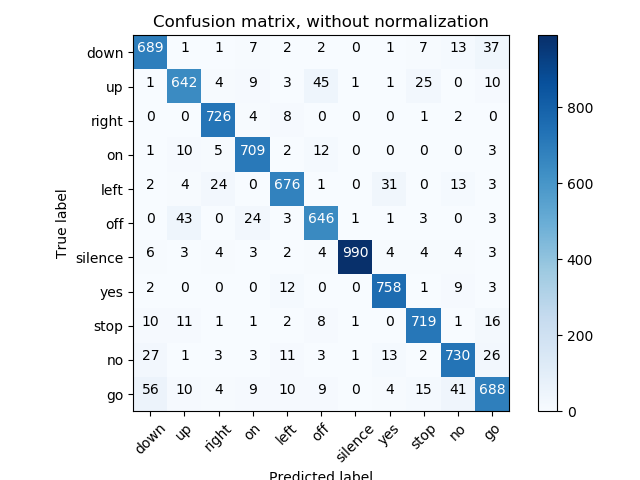

Confusion matrix, without normalization


<IPython.core.display.Javascript object>


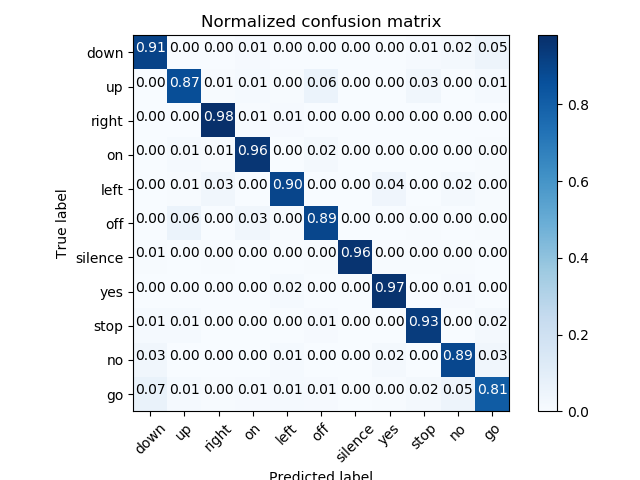

Normalized confusion matrix


In [159]:
# Plot normalized confusion matrix
plt.figure()
functions.plot_confusion_matrix(preds, y_test, classes=labelList, normalize=True,
                      title='Normalized confusion matrix')
precision = cnn.evaluate([x_train[:,:,:,0, np.newaxis], x_train[:,:,:,1, np.newaxis], x_train[:,:,:,2, np.newaxis]],  y_train)
#print ("Precision: ", round(precision*100,2),"%")

# Output of conv2D

In [ ]:
cnn_copy = Sequential()
cnn_copy.add(cnn.layers[0])
result = cnn_copy.predict(x_test)


In [ ]:
plt.figure()
plt.imshow(result[0,:,:,0])

# Save Model

In [ ]:
dest_directory = 'model_backup/'
if not os.path.exists(dest_directory):
      os.makedirs(dest_directory)
name = 'cnn.bak'
cnn.save(dest_directory + name)

#bak = load_model(dest_directory + name)


In [ ]:
model = Model(input_shape=(x_train.shape[1], x_train.shape[2],1))
model.add(Conv2D(100, (4,4),  strides = (1,1), padding="valid"))
model.add(Conv2D(100, (4,2),  strides = (1,1), padding="valid"))
model.add(MaxPooling2D_drawer(pool_size=(3,3)))
model.add(Conv2D(128, (4,2),  strides = (1,1), padding="valid"))
model.add(Conv2D(128, (5,2),  strides = (1,1), padding="valid"))
model.add(MaxPooling2D_drawer(pool_size=(4,1)))
model.add(Flatten_drawer())
model.add(Dense_drawer(100))
model.add(Dense_drawer(y_train.shape[1]))

#save to pdf
save_model_to_file(model, "example.pdf")

# Looking for hyperparameters

In [ ]:
from keras.activations import softmax
from keras.layers.advanced_activations import LeakyReLU
from keras.models import Sequential, load_model
from keras.layers import Dense, Activation, Flatten, Dropout, Convolution2D, MaxPooling2D, AveragePooling2D, BatchNormalization
trials = Trials()
best_run, best_model = optim.minimize(model=functions.create_model, 
                                      data=functions.data,
                                      algo=tpe.suggest,
                                      max_evals=100,
                                      trials=trials,
                                      notebook_name='Processing')

In [ ]:
dest_directory = 'model_backup/'
'''
best_model = load_model(dest_directory + 'best_model.bak')

with open(dest_directory+'best_run.pkl', 'rb') as f:  
    best_run = pickle.load(f)    
'''
print("Evalutation of best performing model:")
print(best_model.evaluate(x_test, y_test))
print("Best performing model chosen hyper-parameters:")
print(best_run)
best_model.summary()




now = datetime.datetime.now()
dest_directory_temp =dest_directory + 'bestModel('+now.strftime("%m-%d %H.%M")+")"
if not os.path.exists(dest_directory_temp):
      os.makedirs(dest_directory_temp)
best_model.save(dest_directory_temp + '/best_model.bak')

with open(dest_directory_temp + '/best_run.pkl', 'wb') as f:  
    pickle.dump(best_run, f)



In [ ]:
trials.best_trial